In [100]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice

from datetime import datetime, timedelta, timezone
from pathlib import Path

In [102]:
from lropy.analysis.spice_tools import as_et, as_utc, as_tdb, generate_lro_ephemeris
from lropy.analysis.io import load_simulation_results, load_all_simulation_results, load_pickled_simulation_results, pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.transform import spher2cart, cart2spher, align_vectors
from lropy.analysis.util import get_day_index, trim_df, get_revolutions_index
from lropy.constants import moon_polar_radius

In [148]:
def plot_accelerations(dfs, labels, sources=None):
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    if sources is None:
        sources = ["moon"] * len(dfs)

    for df, label, source in zip(dfs, labels, sources):
        ax_mag.plot(df.index, df[f"acc_rp_{source}"], label=label)
        ax_radial.plot(df.index, df[f"acc_rp_{source}_radial"])
        ax_along.plot(df.index, df[f"acc_rp_{source}_along"])
        ax_cross.plot(df.index, df[f"acc_rp_{source}_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
    
    format_plot(major_grid=True)

# Effect of instantaneous reradiation

In [104]:
results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)

In [105]:
metadata_rerad

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,a6501,eudoxos,2023-08-19T11:39:01.826573,/home2/dominik/dev/lropy/results/instantaneous...,2011 SEP 26 18:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,5,True,18.353597,[19.10147862136364]
2,620ca,eudoxos,2023-08-19T11:39:01.826615,/home2/dominik/dev/lropy/results/instantaneous...,2010 JUN 28 15:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,5,True,18.145782,[18.886169772595167]
3,99f1c,eudoxos,2023-08-19T11:39:01.826633,/home2/dominik/dev/lropy/results/instantaneous...,2010 JUN 28 15:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,5,True,18.491977,[19.242287643253803]
4,7daaa,eudoxos,2023-08-19T11:39:01.826647,/home2/dominik/dev/lropy/results/instantaneous...,2011 SEP 26 18:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,5,True,20.110302,[20.855859387665987]
5,2f92b,eudoxos,2023-08-19T11:39:01.826659,/home2/dominik/dev/lropy/results/instantaneous...,2010 JUN 28 15:00:00,Paneled,False,True,False,False,,0,[],,,13563.4,5,True,14.352405,[15.073216816410422]
6,df97a,eudoxos,2023-08-19T11:39:01.826671,/home2/dominik/dev/lropy/results/instantaneous...,2011 SEP 26 18:00:00,Paneled,False,True,False,False,,0,[],,,13563.4,5,True,14.338987,[15.063640976324677]


In [149]:
def plot_rp(source, start_date):
    fig, axs = plt.subplots(4, figsize=(12, 7))

    df_with_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]
    df_without_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]

    for comp, ax in zip(["magnitude", "radial", "along", "cross"], axs):
        ax.set_title(comp)

        if comp == "magnitude":
            col = f"acc_rp_{source}"
        else:
            col = f"acc_rp_{source}_{comp}"

        ax.plot(get_revolutions_index(df_without_rerad), df_without_rerad[col], label="Without instantaneous reradiation", zorder=3)
        ax.plot(get_revolutions_index(df_with_rerad), df_with_rerad[col], label="With instantaneous reradiation", zorder=4)
        ax.plot(get_revolutions_index(df_with_rerad), df_with_rerad[col] * df_without_rerad[col].abs().max() / df_with_rerad[col].abs().max(), label="With instantaneous reradiation (scaled))", c="C1", alpha=0.5, zorder=2)
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])

    axs[0].legend()

    format_plot(major_grid=True, minor_grid=True)

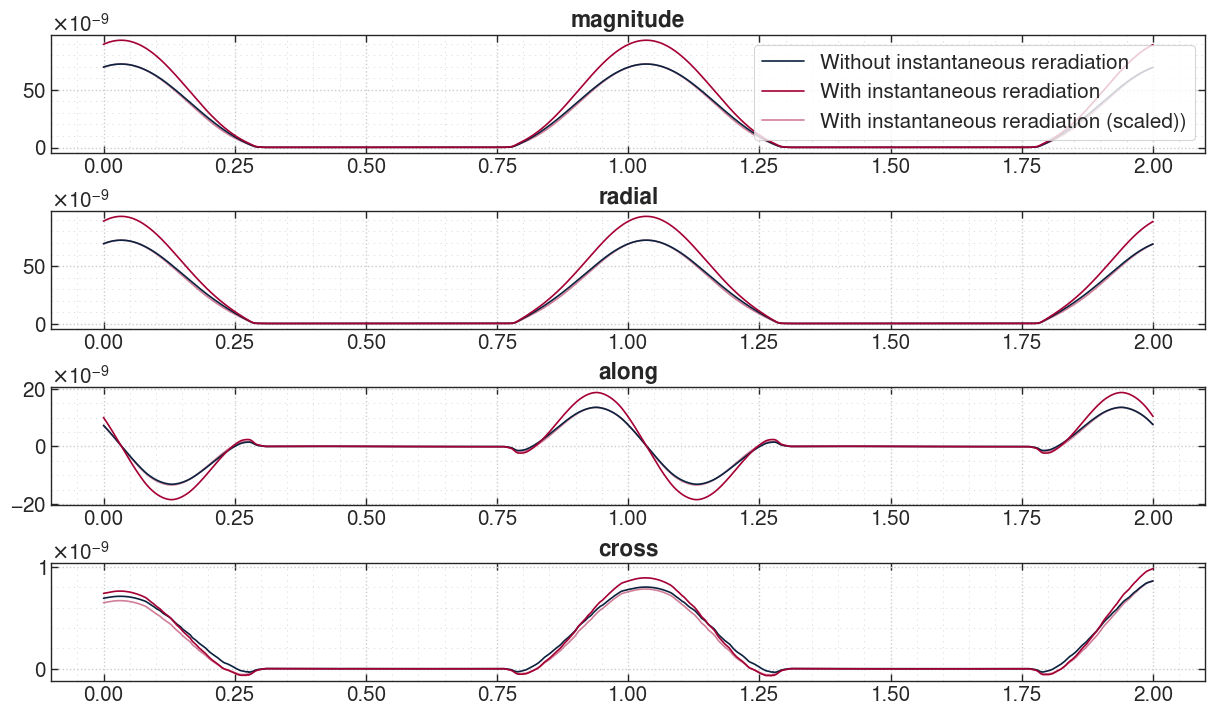

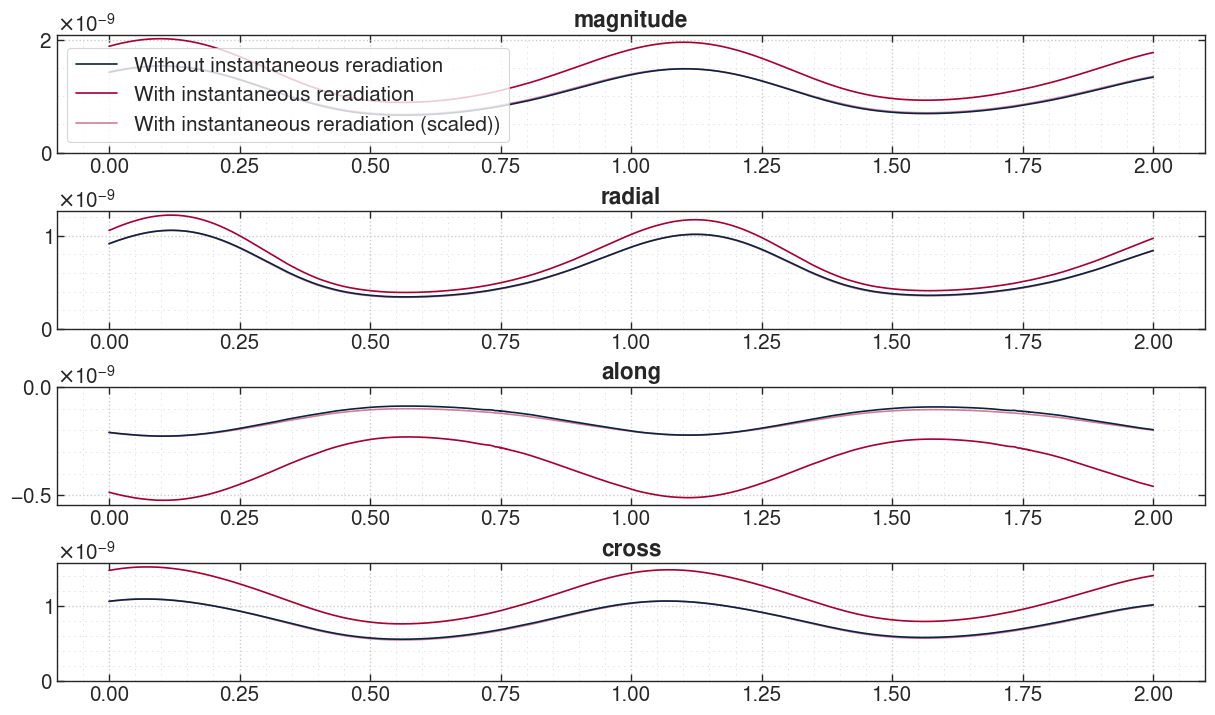

In [150]:
plot_rp("moon", "2011 SEP 26 18:00:00")
plot_rp("moon", "2010 JUN 28 15:00:00")

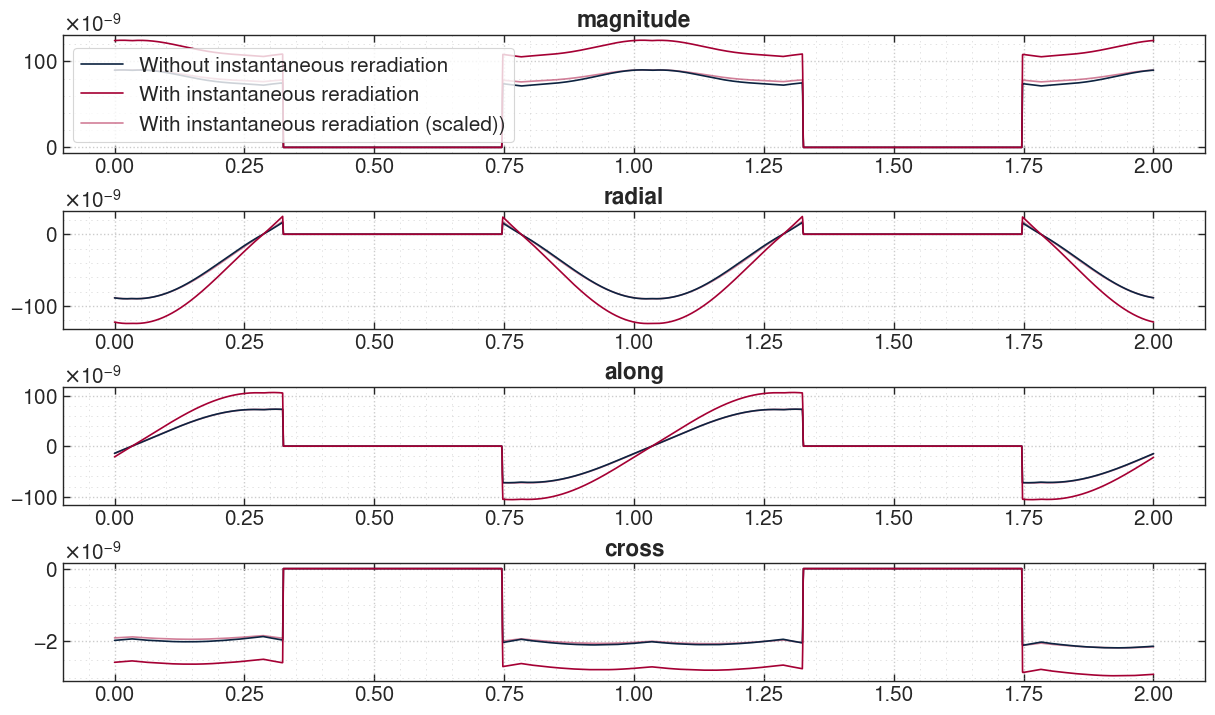

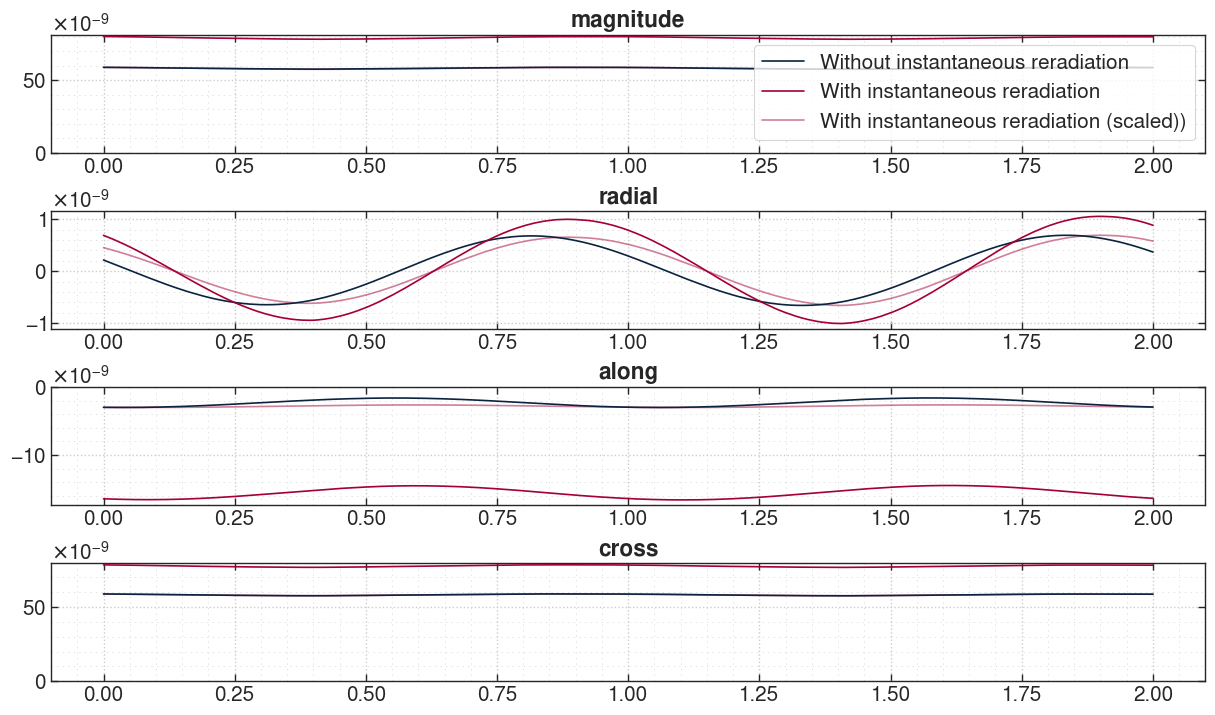

In [151]:
plot_rp("sun", "2011 SEP 26 18:00:00")
plot_rp("sun", "2010 JUN 28 15:00:00")

Shape of both is slightly different, i.e. instantaneous reradiation is not simply a factor.

# Relative contribution of albedo and thermal

In [152]:
results_folder_contribs = Path("../results/albedo_thermal_test-2023-08-19T11-39-46-c9586")
metadata_contribs, runs_contribs = load_pickled_simulation_results(results_folder_contribs)

In [153]:
metadata_contribs

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,c068f,eudoxos,2023-08-19T11:39:46.833528,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",NoAlbedo,Delayed,13563.4,5,True,20.07173,[20.941876467317343]
2,8d892,eudoxos,2023-08-19T11:39:46.833554,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",DLAM1,NoThermal,13563.4,5,True,33.462973,[34.30040472000837]
3,bbb78,eudoxos,2023-08-19T11:39:46.833569,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 28 15:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,5,True,18.812221,[19.65817480534315]
4,bc61f,eudoxos,2023-08-19T11:39:46.833582,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 28 15:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",DLAM1,NoThermal,13563.4,5,True,40.197774,[41.519492372870445]
5,07012,eudoxos,2023-08-19T11:39:46.833592,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,Delayed,13563.4,5,True,26.707993,[28.04429945908487]
6,51e4c,eudoxos,2023-08-19T11:39:46.833604,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 28 15:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,NoThermal,13563.4,5,True,26.356754,[27.713711824268103]
7,2509e,eudoxos,2023-08-19T11:39:46.833616,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 28 15:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",DLAM1,NoThermal,13563.4,5,True,32.347937,[33.18904377147555]
8,eb7f7,eudoxos,2023-08-19T11:39:46.833630,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",DLAM1,Delayed,13563.4,5,True,39.42559,[40.74481956847012]
9,218ee,eudoxos,2023-08-19T11:39:46.833642,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,Delayed,13563.4,5,True,18.753182,[19.60711181163788]
10,ba1b5,eudoxos,2023-08-19T11:39:46.833651,/home2/dominik/dev/lropy/results/albedo_therma...,2011 SEP 26 18:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",DLAM1,AngleBased,13563.4,5,True,40.82298,[42.14427928254008]


In [154]:
def get_contrib_run(albedo, thermal, target_type, start_date):
    for date in metadata_contribs["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    idx = metadata_contribs[
        (metadata_contribs["albedo_distribution_moon"] == albedo) &
        (metadata_contribs["thermal_type_moon"] == thermal) &
        (metadata_contribs["target_type"] == target_type) &
        (metadata_contribs["simulation_start"] == start_date)
    ]
    if len(idx.index) > 1:
        raise ValueError("More than one run found")
    return runs_contribs[idx.index[0]]

### Orbital period

6778.992000481557 6785.467239926973 6781.625836962618 113.0270972827103
6779.689952605076 6788.937565293822 6784.416916527401 113.07361527545667


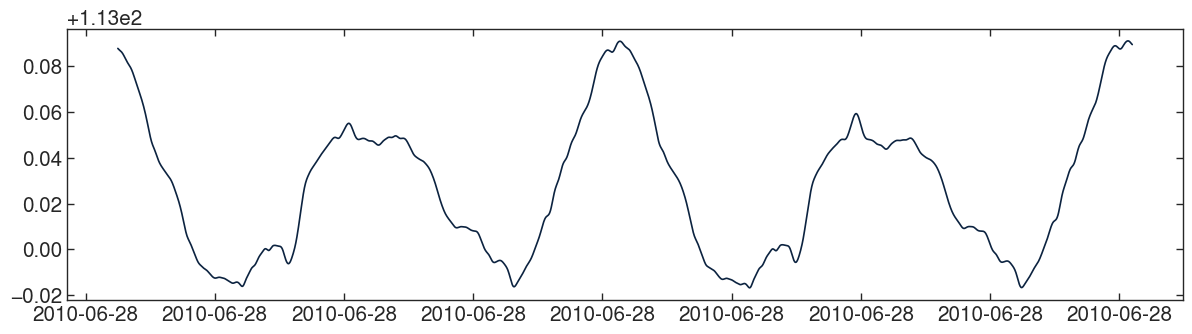

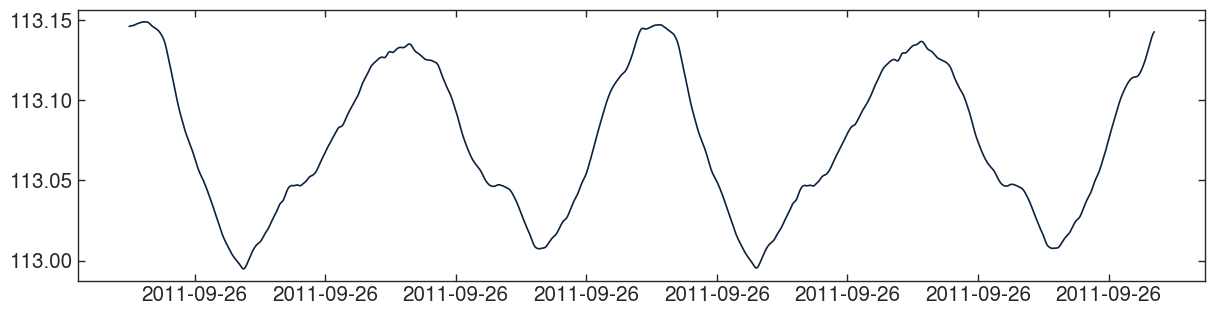

In [155]:
def plot_orbital_period(date):
    gm_moon = 4.9048695e12
    df = get_contrib_run("DLAM1", "AngleBased", "Paneled", date)

    period = np.sqrt(df["kepler_a"]**3 / gm_moon) * 2 * np.pi
    print(period.min(), period.max(), period.mean(), period.mean() / 60)

    plt.subplots()
    plt.plot(df.index, period / 60)

    format_plot()

plot_orbital_period("2010 JUN 28")
plot_orbital_period("2011 SEP 26")

### Solar vs lunar albedo

Expected solar RP acceleration from Lucchesi (2006) Eq. 2:

In [156]:
distance_moon_sun = 152460762e3  # m
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * distance_moon_sun**2)
c = 299792458  # m/s
radiation_pressure = solar_irradiance / c

14.0 / 1087 * 1.0 * radiation_pressure

5.630198174778997e-08

which agrees with Smith's results and ours for cannonball (with mass 1208 and area 11.5 m2). Our paneled results correspond to a cannonball coefficient of 1.6, which can occur (Mazarico 2018, Fig. 15).

Expected albedo RP acceleration from Lucchesi (2006) Eq. 17:

In [157]:
0.15 / 2 * (moon_polar_radius / (moon_polar_radius + 50))**2 * 5.63e-8

4.2222567789410525e-09

which agrees with our results, not Smiths.
* Factor 1/2 in expected albedo RP probably due to ratio 1/2 of visible projected disk area to irradiated hemisphere area

1.7116891748781689
5.845376501846039e-08
0.0 1360.6132650741


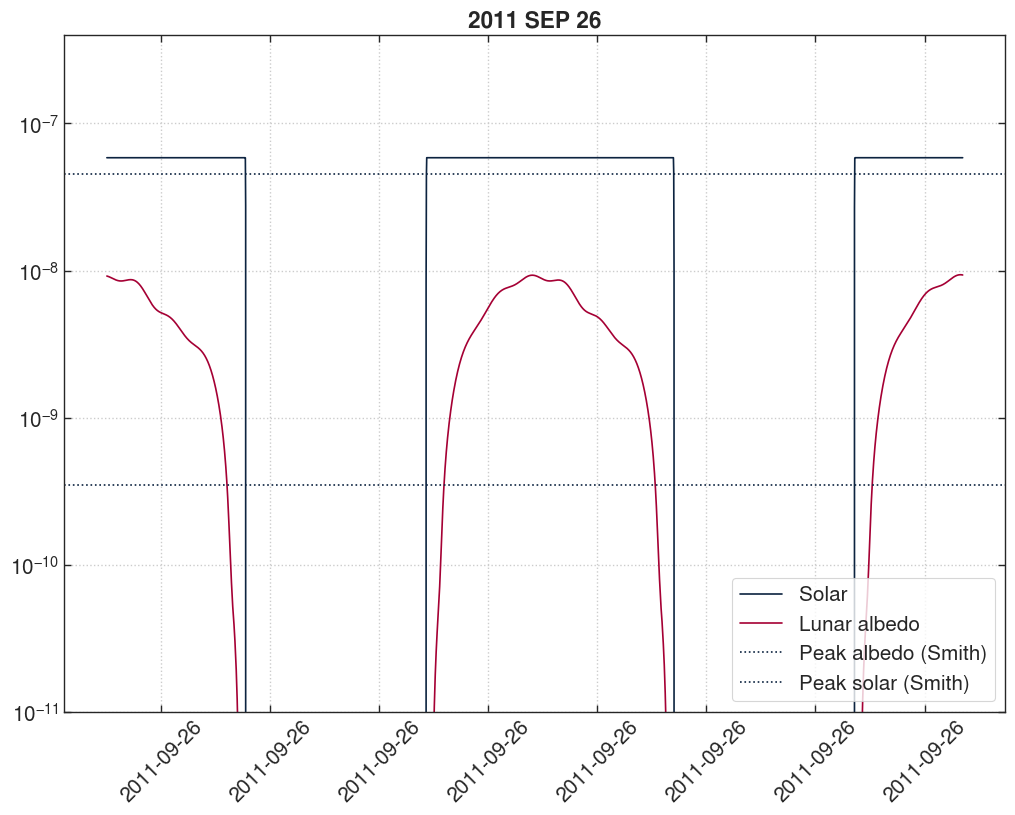

In [158]:
def plot_solar_vs_albedo():
    start_date = "2011 SEP 26"
    # start_date = "2010 AUG 04"
    df = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex="all")

    ax.plot(df.index, df["acc_rp_sun"], label="Solar")
    ax.plot(df.index, df["acc_rp_moon"], label="Lunar albedo")
    print(df["angle_subsolar"].min())
    print(df["acc_rp_sun"].max())
    print(df["irr_sun"].min(), df["irr_sun"].max())

    ax.axhline(3.5e-10, label="Peak albedo (Smith)", ls=":")
    ax.axhline(4.5e-8, label="Peak solar (Smith)", ls=":")

    ax.legend()
    ax.set_title(start_date)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([1e-11, 4e-7])
    ax.set_yscale("log")
    
    format_plot(major_grid=True)

plot_solar_vs_albedo()

Considerations for finding arc from Smith (2008):
* In their figure, 64% of orbit is not eclipsed. This occurs around August 4. Around August 29, 59% of the orbit is not eclipsed.
* February arc with 64% non-eclipse has very different albedo behavior -> must be August 4

### DLAM-1 vs constant albedo

In [159]:
def plot_albedo_type(start_date):
    df_albedo_constant = get_contrib_run("Constant", "NoThermal", "Cannonball", start_date)
    df_albedo_dlam = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    plot_accelerations([df_albedo_constant, df_albedo_dlam], ["Constant", "DLAM-1"])

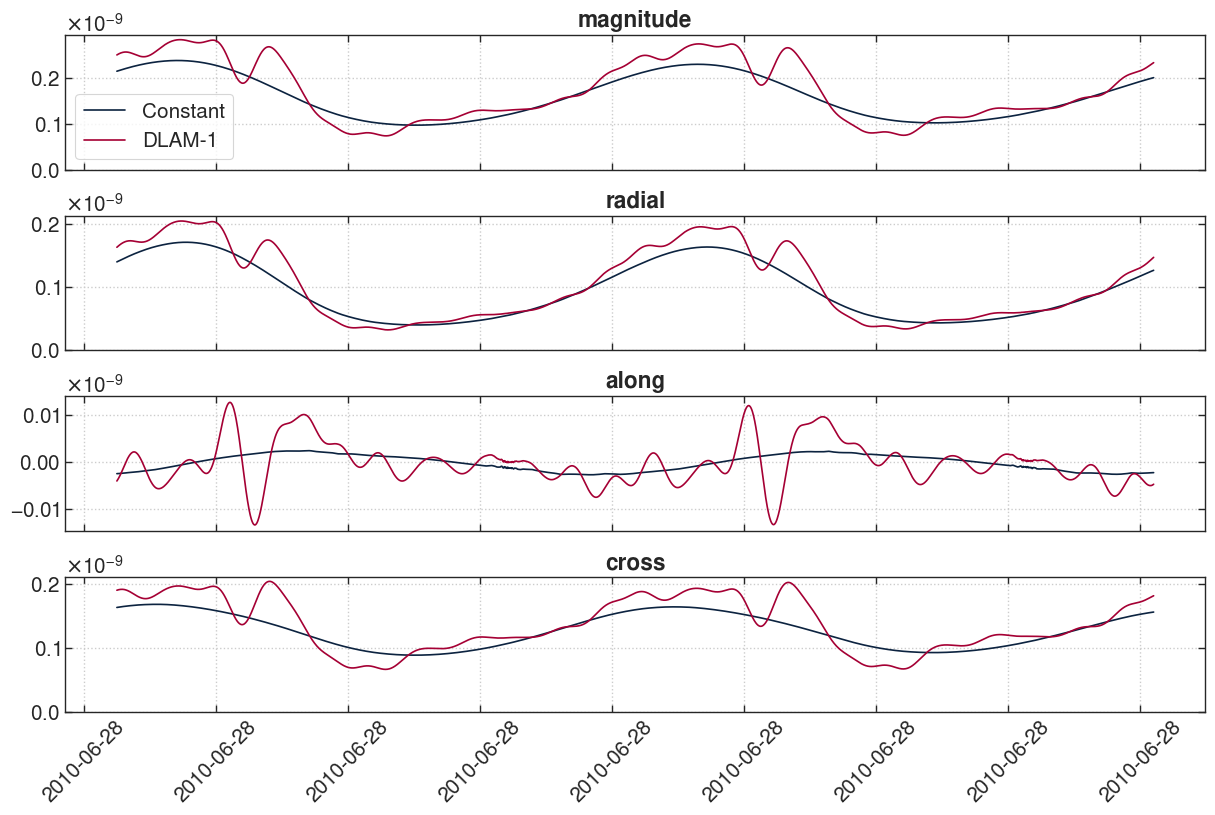

In [160]:
plot_albedo_type("2010 JUN 28")

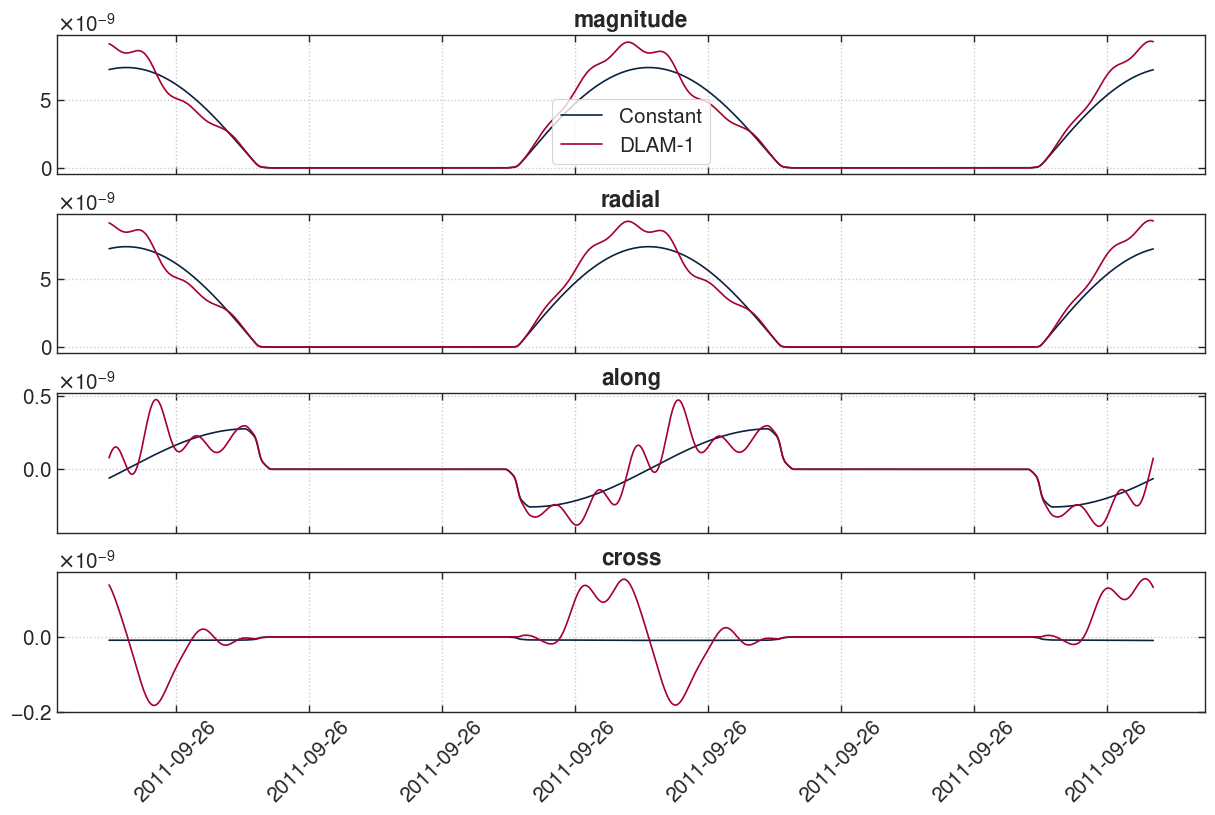

In [161]:
plot_albedo_type("2011 SEP 26")

### Delayed vs angle-based thermal radiation

In [162]:
def plot_thermal_type(start_date):
    df_albedo_angle_based = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    df_albedo_delayed = get_contrib_run("NoAlbedo", "Delayed", "Cannonball", start_date)
    plot_accelerations([df_albedo_angle_based, df_albedo_delayed], ["Angle-based", "Delayed"])

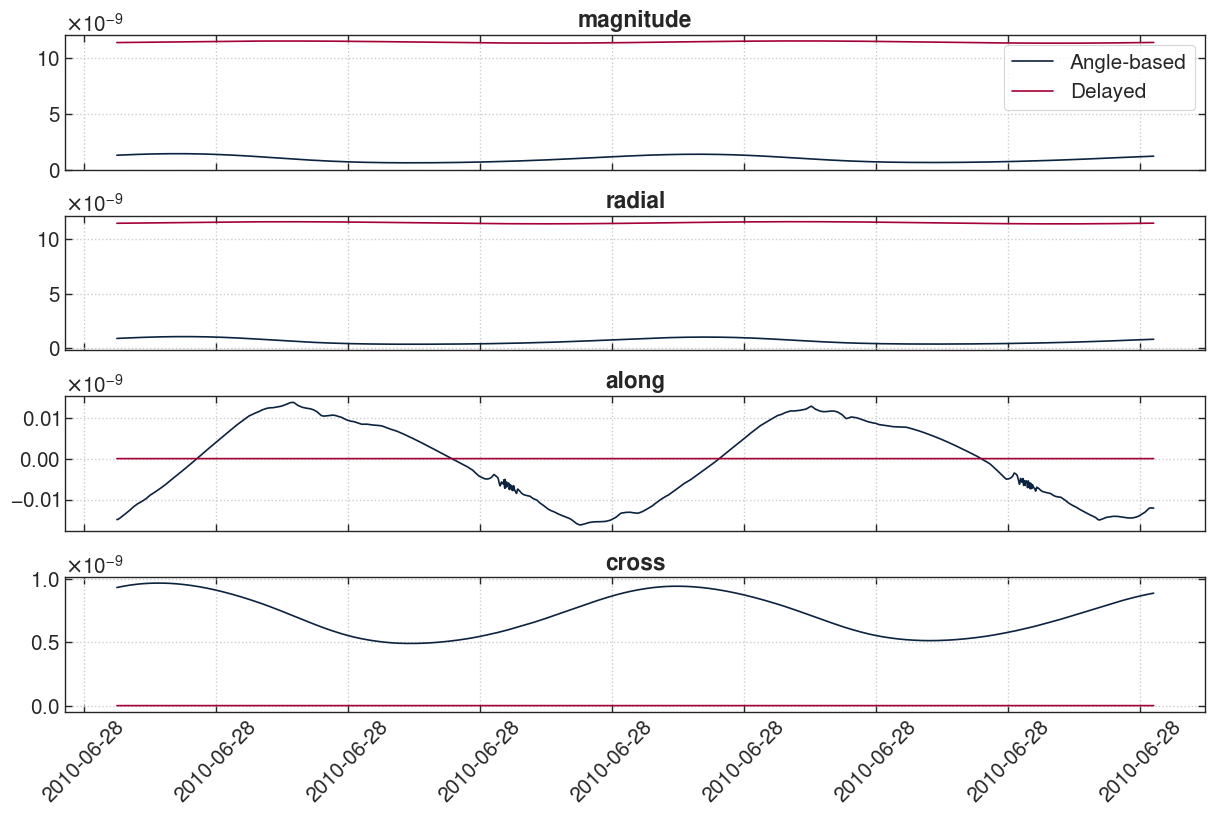

In [163]:
plot_thermal_type("2010 JUN 28")

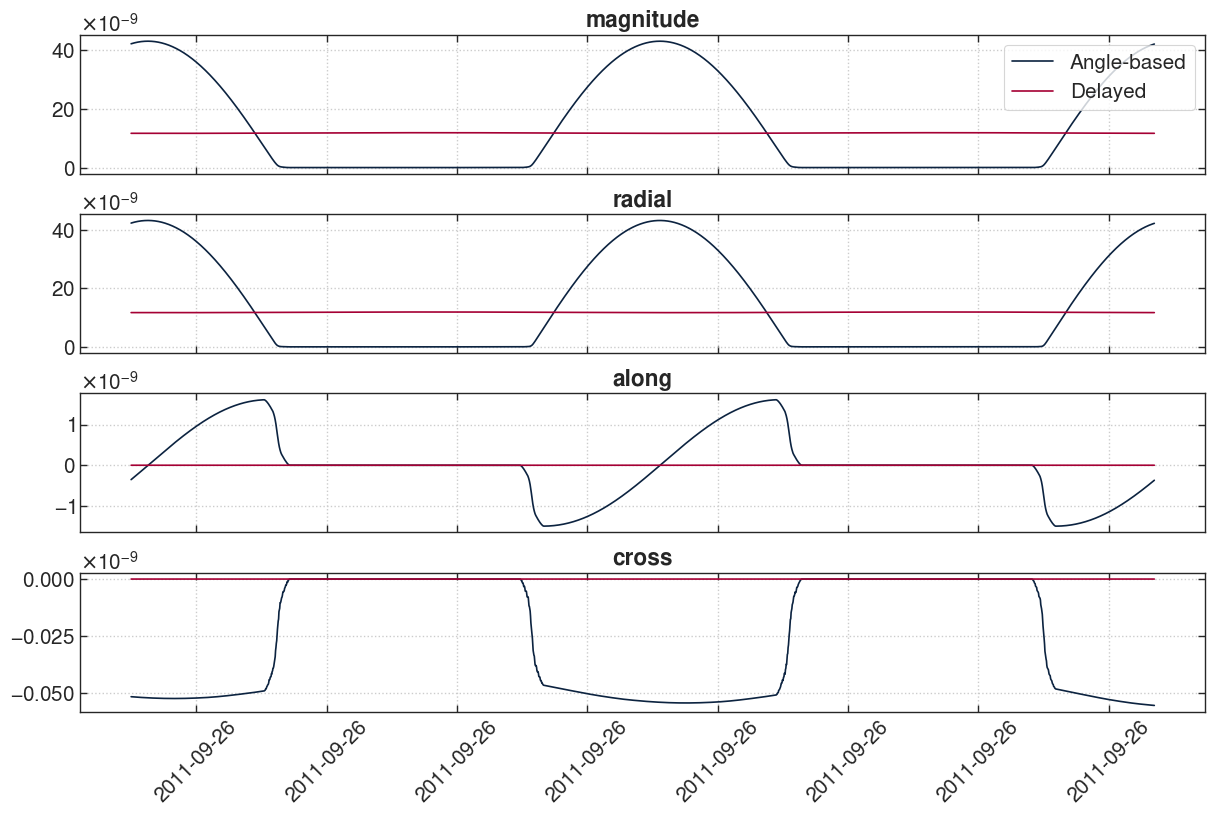

In [164]:
plot_thermal_type("2011 SEP 26")

Delayed model has constant radial acceleration and no cross/along acceleration since emissivity is constant.

### Albedo vs thermal radiation

In [165]:
def plot_albedo_vs_thermal(start_date):
    df_albedo = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    df_thermal = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    plot_accelerations([df_albedo, df_thermal], ["Albedo (DLAM-1)", "Thermal (angle-based)"])

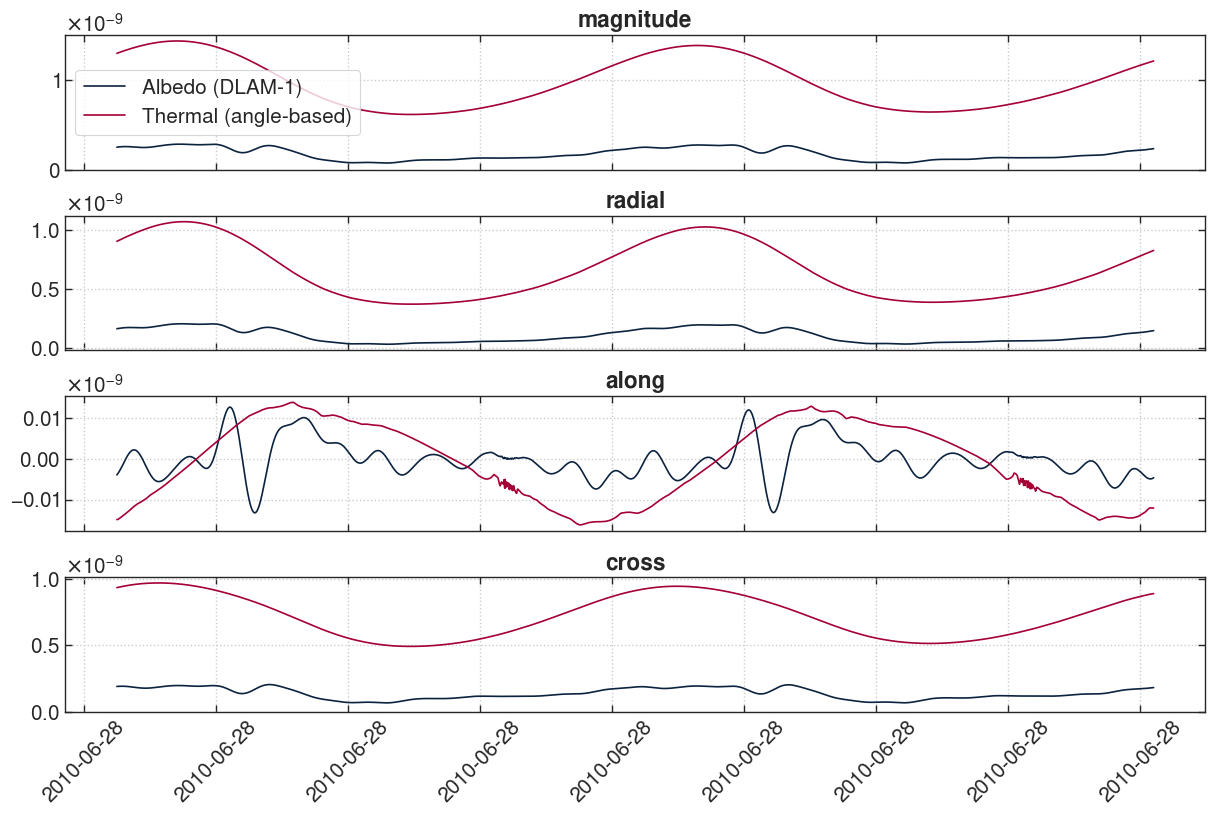

In [166]:
plot_albedo_vs_thermal("2010 JUN 28")

### Solar vs lunar

In [167]:
def plot_solar_vs_lunar(start_date):
    df = get_contrib_run("Constant", "AngleBased", "Cannonball", start_date)
    plot_accelerations([df, df], ["Solar", "Lunar"], ["sun", "moon"])

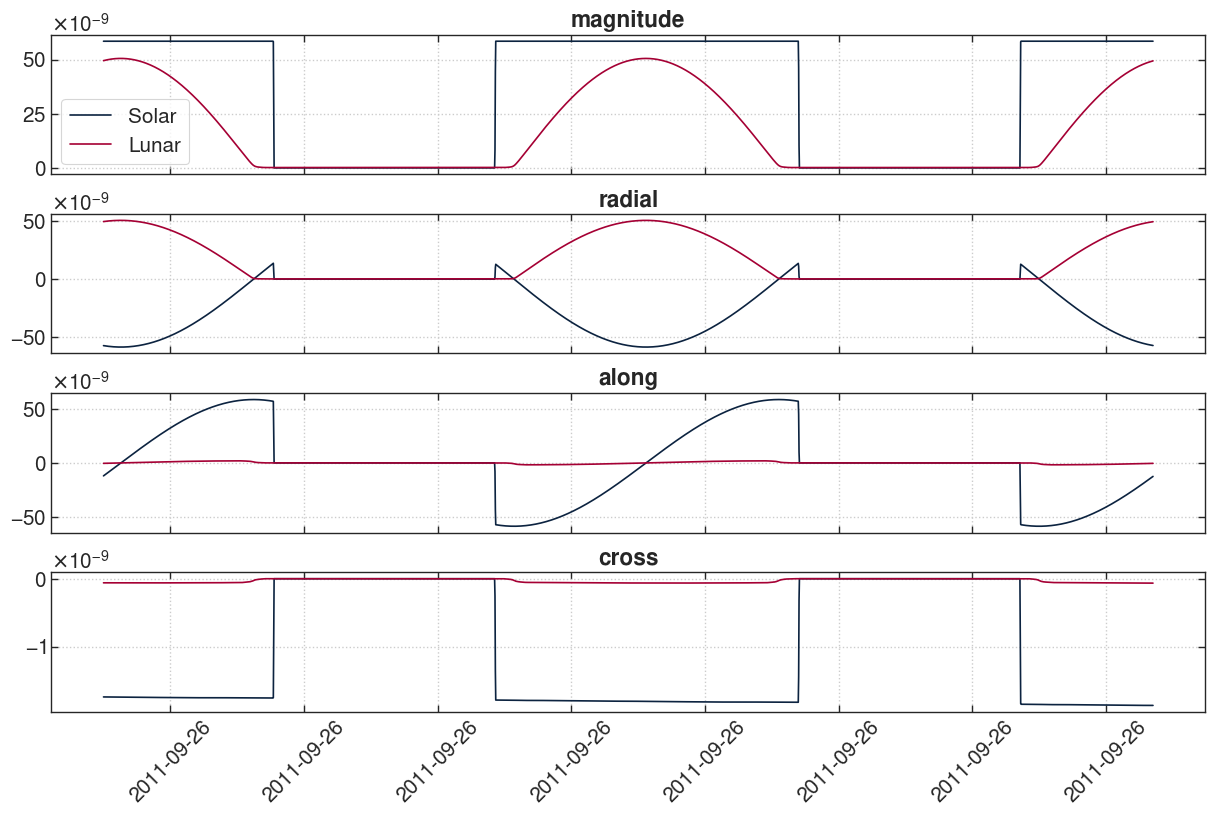

In [168]:
plot_solar_vs_lunar("2011 SEP 26")

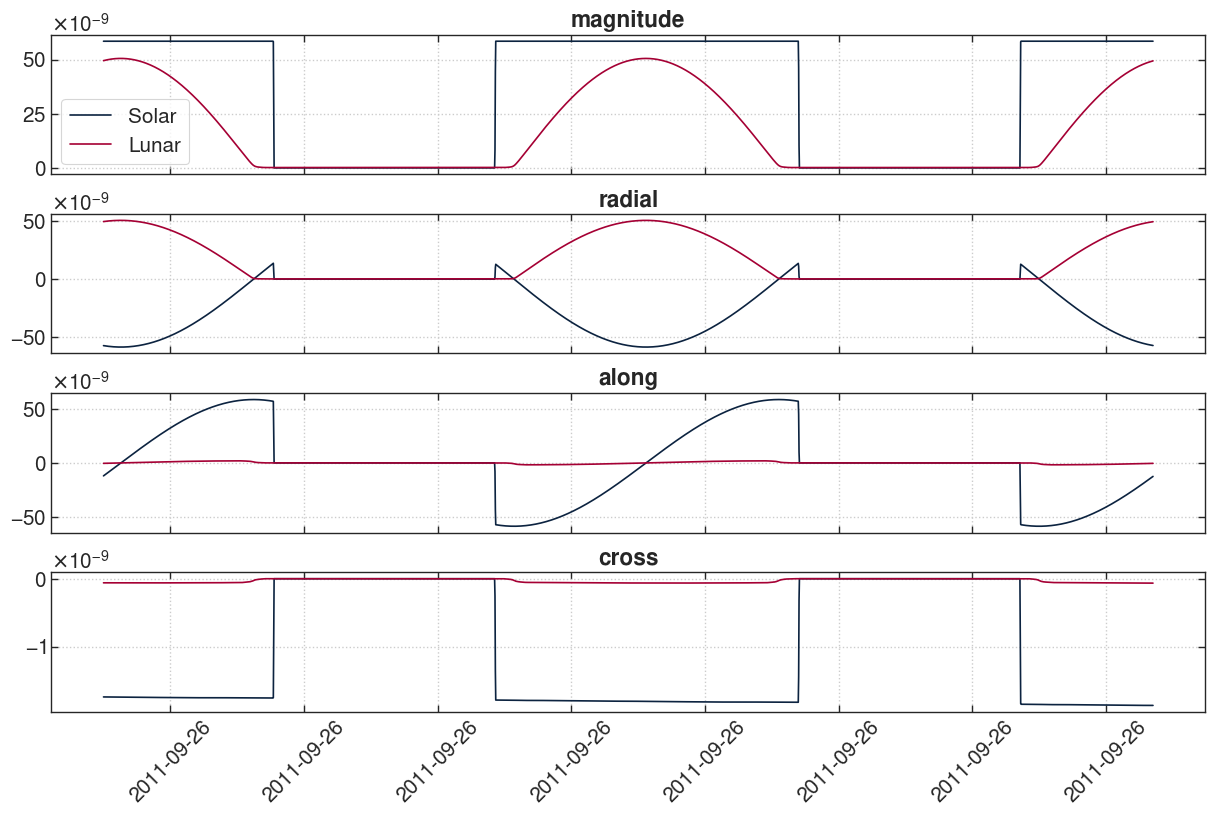

In [169]:
plot_solar_vs_lunar("2011 SEP 26")

# Effect of number of rings

In [170]:
results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T14-33-31-ffcd7/")
metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

In [171]:
metadata_rings

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,63707,eudoxos,2023-08-17T14:33:31.755338,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,AngleBased,13563.4,10,True,15.841007,[16.603067522868514]
2,f9aba,eudoxos,2023-08-17T14:33:31.755365,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,10,True,10.70469,[11.465850479900837]
3,0fbfc,eudoxos,2023-08-17T14:33:31.755384,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",DLAM1,AngleBased,13563.4,10,True,53.352015,[54.10110993869603]
4,72c19,eudoxos,2023-08-17T14:33:31.755397,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56]",Constant,AngleBased,13563.4,10,True,12.178729,[12.936120184138417]
5,31113,eudoxos,2023-08-17T14:33:31.755409,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",DLAM1,AngleBased,13563.4,10,True,43.164216,[43.917736418545246]
6,b4822,eudoxos,2023-08-17T14:33:31.755420,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",Constant,AngleBased,13563.4,10,True,16.589568,[17.35687855631113]
7,54d77,eudoxos,2023-08-17T14:33:31.755433,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66]",Constant,AngleBased,13563.4,10,True,13.480387,[14.23343831859529]
8,b090f,eudoxos,2023-08-17T14:33:31.755448,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",Constant,AngleBased,13563.4,10,True,15.754013,[16.511640552431345]
9,2806a,eudoxos,2023-08-17T14:33:31.755460,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48]",Constant,AngleBased,13563.4,10,True,11.536688,[12.295958243310452]
10,0808b,eudoxos,2023-08-17T14:33:31.755470,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42]",Constant,AngleBased,13563.4,10,True,11.178419,[11.931176571175456]


In [172]:
def get_dfs_rings(albedo):
    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == albedo)
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    return dict(sorted(dfs.items(), key=lambda item: item[0]))

In [173]:
def plot_convergence_magnitude(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        ax.plot(get_revolutions_index(df), df["irr_moon"], label=f"{label} rings", c=color)

    ax.set_title("Irradiance")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

In [174]:
def plot_convergence_error(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        # df = df.iloc[idx_start:idx_end]
        ax.plot(get_revolutions_index(df), (df["irr_moon"] - df_ref["irr_moon"]).abs(), label=f"{label} rings", c=color)

    ax.set_title("Irradiance absolute difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

In [175]:
def plot_convergence_error_relative(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        ax.plot(get_revolutions_index(df), (df["irr_moon"] - df_ref["irr_moon"]).abs() / df_ref["irr_moon"], label=f"{label} rings", c=color)

    ax.set_title("Irradiance relative difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

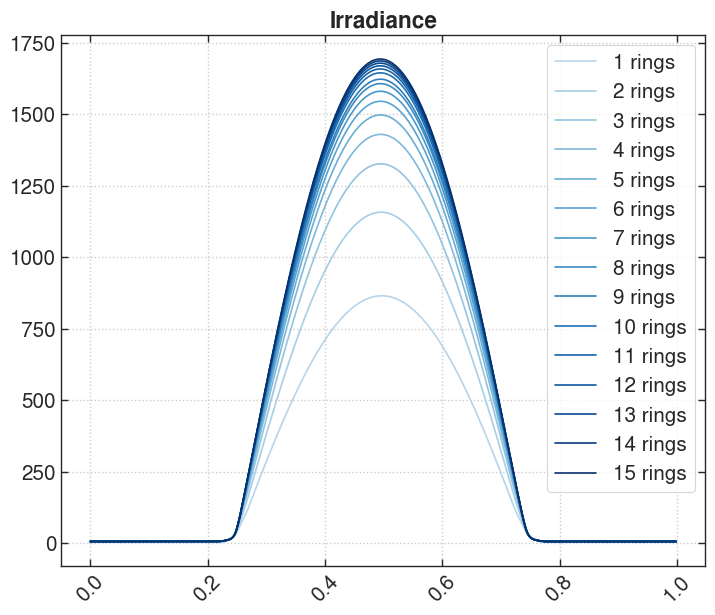

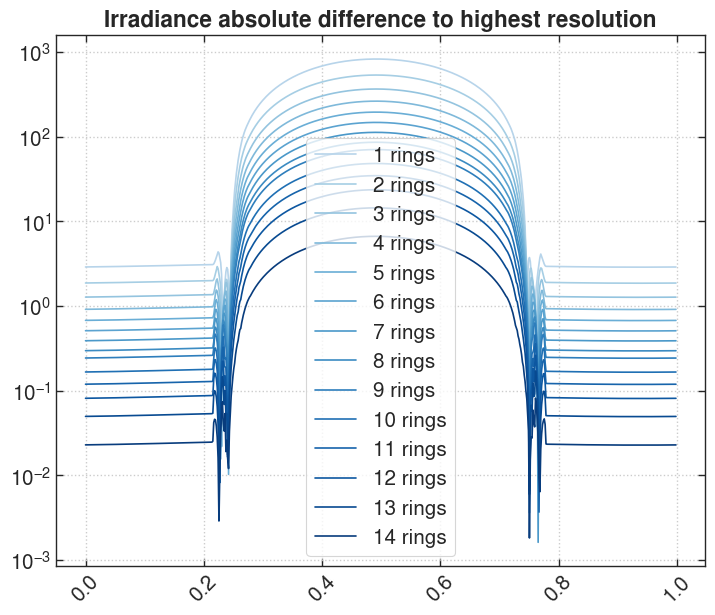

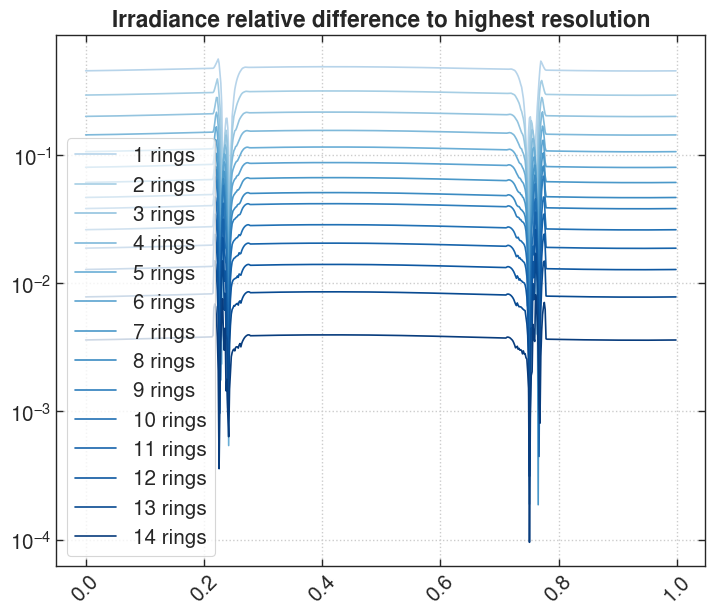

In [176]:
dfs_convergence = get_dfs_rings("Constant")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())

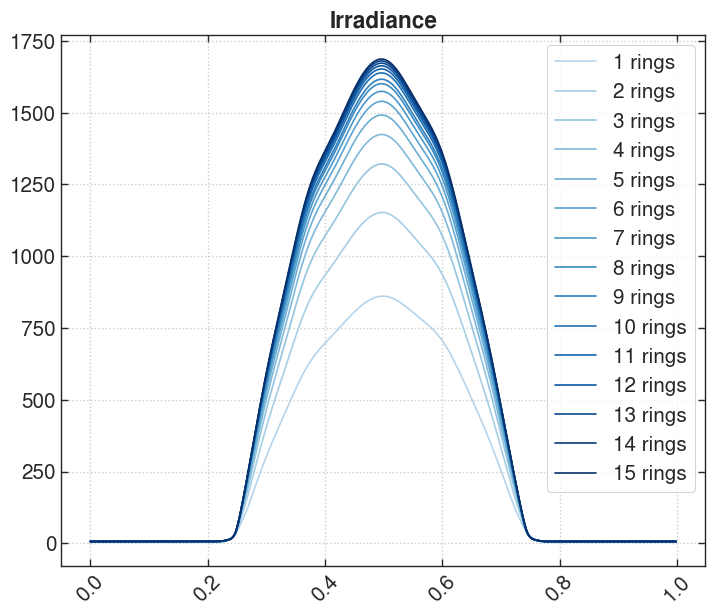

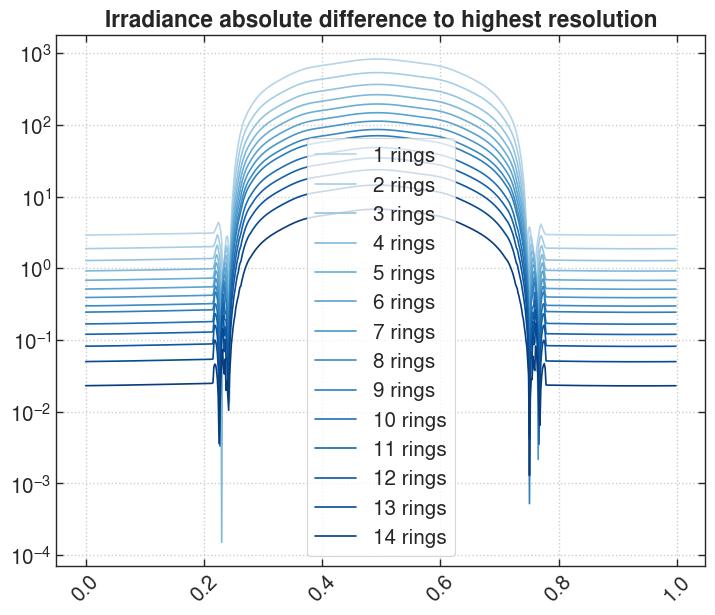

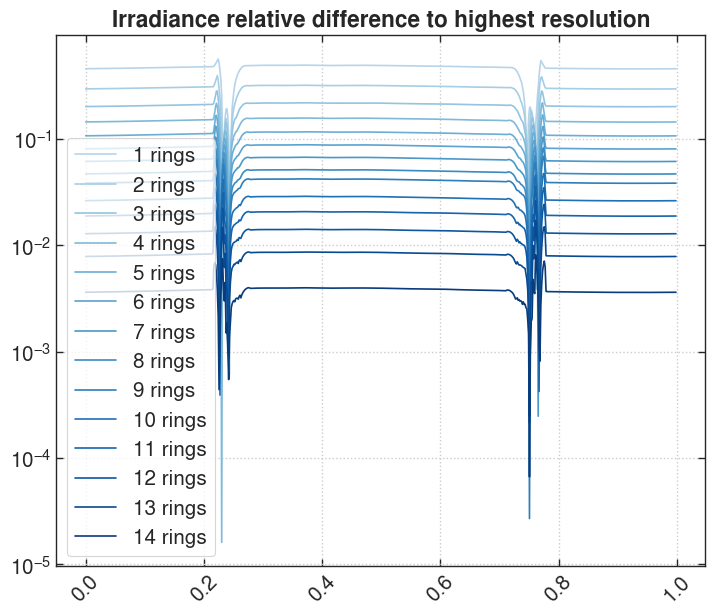

In [177]:
dfs_convergence = get_dfs_rings("DLAM1")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())

8 rings (error 8.2%) are required to bring the error below 10% at all times. The largest relative errors occur when crossing the terminator, however, at which point the accelerations are small in any case. To bring the peak error below 10%, only 6 panels (peak error 8.7%) are needed.